<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S9_Custom_Transformer_CIFAR/S9_Transformer_Ultimus_Block_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running a custom model to understand self-attention mechanism from models.py
## Running a model on CIFAR10 dataset
## Leveraing GradCam to produce activation maps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%autoreload 2
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/navrat/EVA_phase1_2022_23 -q --quiet
!mv EVA_phase1_2022_23/CIFAR_Pytorch/* .
print("Loaded EVA8 Modules and Models")

!rm -rf EVA_phase1_2022_23

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA8 Modules and Models
  Preparing metadata (setup.py) ... done


## Loading train and test datasets

In [3]:
from utils import *
from main import *

dataset = dataset_cifar10(batch_size=128)

CUDA availability ? True


In [4]:
# Train dataloader
trainloader = dataset.loader(train_flag=True)

# Test dataloader
testloader = dataset.loader(train_flag=False)

target_classes = dataset.classes

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


In [5]:
dataset.data_summary_stats()

training data
Files already downloaded and verified
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
testing data
Files already downloaded and verified
[0.49421428 0.48513139 0.45040909]
[0.24665252 0.24289226 0.26159238]
total data
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


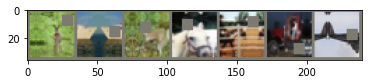

['deer', 'ship', 'frog', 'horse', 'horse', 'truck', 'plane']


In [6]:
# # sample training images
plot_sample_images(trainloader, target_classes, 7)

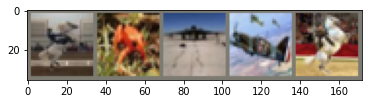

['horse', 'frog', 'plane', 'plane', 'horse']


In [7]:
# sample testing images
plot_sample_images(testloader, target_classes, 5)

In [14]:
# Defining the model - model9 (conv block -> ultimus blocks -> FC)
from models.model9 import *
import torch

# Loading Custom_Attention Model
net = Custom_Attention_Model()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


In [15]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 48, 26, 26]          13,872
              ReLU-8           [-1, 48, 26, 26]               0
       BatchNorm2d-9           [-1, 48, 26, 26]              96
AdaptiveAvgPool2d-10             [-1, 48, 1, 1]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
    

## Implementing one cycle policy

In [16]:
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import copy
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

In [18]:
# One cycle implementation
net_exp = copy.deepcopy(net)
optimizer = torch.optim.SGD(net_exp.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=500)
lr_finder.plot()

  0%|          | 0/500 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-03


ValueError: ignored

In [19]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.0010186289902446874


In [20]:
# Load train and test model
# from main import *
# criterion, optimizer, scheduler, n_epochs = model_training_setup(net)
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# Load train and test model
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,# %of epochs spent increasing LR
                                                div_factor=25,
                                                three_phase=False, # False to not annihilate
                                                final_div_factor=10, # since lr_min needs to be 1/10th of max LR
                                                anneal_strategy='linear'
                                                )
net, history = fit_model_onecycle_LR(
    net=net, device=device,
    criterion = criterion,
    train_loader=trainloader, test_loader=testloader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 4.0745159609787494e-05)


Batch_id=390 Loss=nan Accuracy=10.01%: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 2 (LR: 0.0002445795650785186)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.20it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 3 (LR: 0.0004484139705472497)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:25<00:00, 15.27it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 4 (LR: 0.000652248376015981)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.10it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 5 (LR: 0.000856082781484712)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.06it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 6 (LR: 0.001007925570279418)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 7 (LR: 0.000955084191410475)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 8 (LR: 0.0009022428125415318)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.93it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 9 (LR: 0.0008494014336725887)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 10 (LR: 0.0007965600548036455)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.93it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 11 (LR: 0.0007437186759347023)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.90it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 12 (LR: 0.0006908772970657592)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.10it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 13 (LR: 0.000638035918196816)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 14 (LR: 0.0005851945393278729)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.01it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 15 (LR: 0.0005323531604589297)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.00it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 16 (LR: 0.0004795117815899865)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 17 (LR: 0.00042667040272104334)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 18 (LR: 0.0003738290238521002)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.88it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 19 (LR: 0.00032098764498315695)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.73it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 20 (LR: 0.0002681462661142139)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 21 (LR: 0.00021530488724527067)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 22 (LR: 0.00016246350837632753)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.65it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 23 (LR: 0.00010962212950738439)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 15.96it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 24 (LR: 5.678075063844125e-05)


Batch_id=390 Loss=nan Accuracy=10.00%: 100%|██████████| 391/391 [00:24<00:00, 16.16it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)



In [39]:
history[3]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

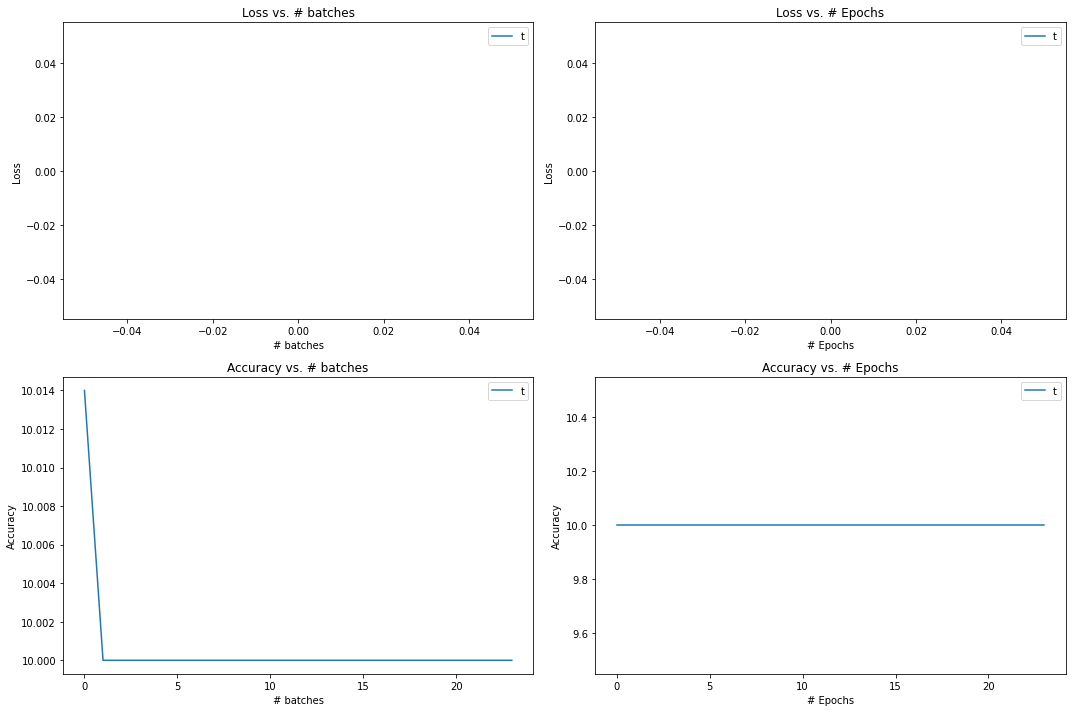

In [44]:
from utils import plot_evolution_graph_onecycle_LR
plot_evolution_graph_onecycle_LR(history)

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
model_save_name = 's9_custom_attention_model.pt'
path = F"/content/gdrive/MyDrive/eva8_models/{model_save_name}" 
torch.save(net.state_dict(), path)

In [13]:
model_save_name = 's9_custom_attention_model.pt'
path = F"/content/gdrive/MyDrive/eva8_models/{model_save_name}"
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [35]:
# from utils import plot_evolution_graph
# plot_evolution_graph(trainObj, testObj)

In [23]:
model_eval_f(net, device, trainloader, target_classes) # train performance report


Test set: Average loss: nan, Accuracy: 5000/50000 (10.00%)


 class wise performance: 

  classes  accuracy
0   plane       0.0
1     car       0.0
2    bird       0.0
3     cat       0.0
4    deer       0.0
5     dog       0.0
6    frog       0.0
7   horse     100.0
8    ship       0.0
9   truck       0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        bird       0.00      0.00      0.00      5000
         car       0.00      0.00      0.00      5000
         cat       0.00      0.00      0.00      5000
        deer       0.00      0.00      0.00      5000
         dog       0.00      0.00      0.00      5000
        frog       0.00      0.00      0.00      5000
       horse       0.00      0.00      0.00      5000
       plane       0.10      1.00      0.18      5000
        ship       0.00      0.00      0.00      5000
       truck       0.00      0.00      0.00      5000

    accuracy                           0.10     50000
   macro avg       0.01      0.10      0.02     50000
weighted avg       0.01      0.10      0.02     50000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
model_eval_f(net, device, testloader, target_classes) # test performance report


Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)


 class wise performance: 

  classes  accuracy
0   plane       0.0
1     car       0.0
2    bird       0.0
3     cat       0.0
4    deer       0.0
5     dog       0.0
6    frog       0.0
7   horse     100.0
8    ship       0.0
9   truck       0.0
              precision    recall  f1-score   support

        bird       0.00      0.00      0.00      1000
         car       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
       plane       0.10      1.00      0.18      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 # of incorrect images predicted in test dataset of 10000: 9000


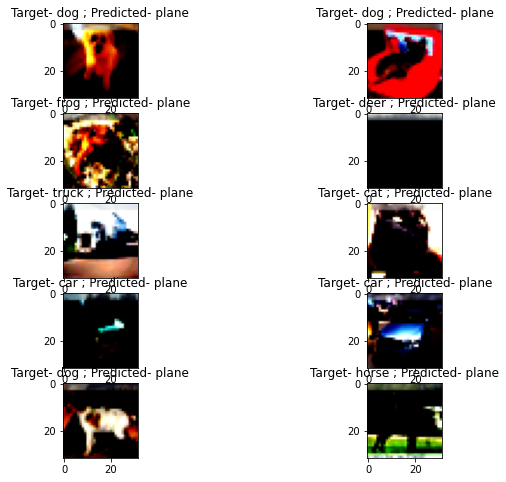



 crosstab of incorrect prediction to understand patterns: 



Predicted,plane
Actual,
bird,1000
car,1000
cat,1000
deer,1000
dog,1000
frog,1000
horse,1000
ship,1000
truck,1000


In [25]:
from utils import plot_mispredictions
plot_mispredictions(net, device, testloader, target_classes, (10,8),10)  # test misclassified images and crosstab report


 # of incorrect images predicted in test dataset of 10000: 9000


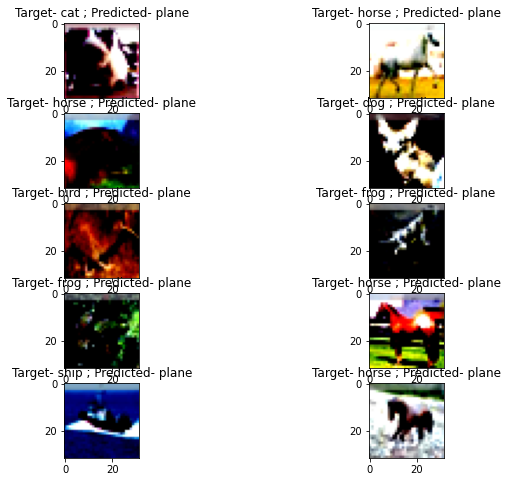



 crosstab of incorrect prediction to understand patterns: 



Predicted,plane
Actual,
bird,1000
car,1000
cat,1000
deer,1000
dog,1000
frog,1000
horse,1000
ship,1000
truck,1000


In [26]:
from utils import plot_mispredictions
plot_mispredictions(net, device, testloader, target_classes, (10,8),10) # test misclassified images and crosstab report

##END